#  Quick look at NIRPS proxima data

In [1]:
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.timeseries import LombScargle
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import nirps_tools as nirps
import yaml

### Read input file

In [2]:
star = input('Enter star name:')

print('Loading input file and data...')
### System info
working_path = f"stars/{star}/"

# Read input file
try: 
    with open(working_path + 'input.yaml', 'r') as file:
        data = yaml.safe_load(file)
except FileNotFoundError:
    print('This star does not exist in the database.')
    raise

system_info = data['star']  # Initialize as a list of one empty dictionary if no star data found
instruments = data['instruments']
ccf = data['CCF']

print('Done.')

Loading input file and data...
Done.


System info

## Loading the data

In [3]:
tbl = {}
tbl_ccf = {}
rv_off = {}
rv_off_ccf = {}
tlabel = "t"

# Name of files
files = {}

# Adjust the file labels
Dtemp_suf = []

# # Get the CCF data if it exists
for instrument in ccf:
    tbl_ccf[instrument] = {}
    if ccf[instrument]['DRS-3-0-0']: 
        tbl_ccf[instrument]['DRS-3-0-0'] = Table.read(f'stars/{star}/data/{star}_{instrument}_DRS-3-0-0.rdb', format='rdb')
        tbl_ccf[instrument]['DRS-3-0-0'][tlabel] = tbl_ccf[instrument]['DRS-3-0-0']["rjd"] #- extra_off

    if ccf[instrument]['DRS-3-5']:
        tbl_ccf[instrument]['DRS-3-5'] = Table.read(f'stars/{star}/data/{star}_{instrument}_DRS-3-5.rdb', format='rdb')
        tbl_ccf[instrument]['DRS-3-5'][tlabel] = tbl_ccf[instrument]['DRS-3-5']["rjd"] #- extra_off
    

i = 0
for instrument in instruments:
    star_name = system_info.get('name', '')  # Accessing the first element of the star_info list
    ref_star = instruments[instrument].get('ref_star', '')
    suffix = instruments[instrument].get('dtemp_suffix', '')
    bin_label = instruments[instrument].get('bin_label', '')
    pca_label = instruments[instrument].get('pca_label', '')
    Dtemp_suf.append(instruments[instrument].get('dtemp_suffix', ''))
    
    files[instrument] = f'stars/{star}/data/lbl{bin_label}_{instrument}_{star}_{ref_star}{pca_label}'
    
    tbl[instrument] = Table.read(files[instrument]+'.rdb', format='rdb')
    
    # Remove NaNs 
    tbl[instrument] = nirps.remove_nans_from_table(tbl[instrument])
        
    rv_off[instrument] = np.median(tbl[instrument]["vrad"])
    tbl[instrument]["vrad"] -= rv_off[instrument]
    
    if ccf[instrument]['DRS-3-0-0']:
        rv_off_ccf[instrument] = np.median(tbl_ccf[instrument]['DRS-3-0-0']["vrad"])
        tbl_ccf[instrument]['DRS-3-0-0']["vrad"] -= rv_off_ccf[instrument]

    #rjd_bjd_off = 2457000
    #extra_off_factor = 100
    #extra_off = np.floor(tbl[instrument]["rjd"].min() / extra_off_factor) * extra_off_factor
    #t_off = rjd_bjd_off + extra_off


    tbl[instrument][tlabel] = tbl[instrument]["rjd"] #- extra_off
    i+=1

## Timeseries and periodograms

In [4]:
qty_list = {}
qty_labels = {}
qty_units = {}
qty_ccf_list = {}
qty_ccf_labels = {}
qty_ccf_units = {}

i = 0
for instrument in instruments:
    # LBL labels
    qty_list[instrument] = ["vrad", "d2v", "d3v","DTEMP"+Dtemp_suf[i]]
    qty_labels[instrument] = {
        "vrad": "RV",
        "d2v": "D2V",
        "d3v": "D3V",
        "DTEMP"+Dtemp_suf[i]: "$\Delta$T",
    }
    qty_units[instrument] = {
        "vrad": "m/s",
        "d2v": "m$^2$ / s$^2$",
        "d3v": "m$^3$ / s$^3$",
        "DTEMP"+Dtemp_suf[i]: "K",
    }
    
    # CCF labels
    qty_ccf_list[instrument] = ['vrad', 'fwhm', 'bis_span']
    qty_ccf_labels[instrument] = {
        "vrad": "RV",
        "fwhm": "FWHM",
        "bis_span": "bissector"}
    qty_ccf_units[instrument] = {"vrad": "m/s",
        "fwhm": "",
        "bis_span": "",
    }
    

    i+=1

LBL data

/home/plamontagne/nirps/nirps_tools.py:132: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  axes[i, 0].errorbar(t, y, yerr=yerr, fmt=err_fmt, label=err_label, color=color)
/home/plamontagne/nirps/nirps_tools.py:132: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  axes[i, 0].errorbar(t, y, yerr=yerr, fmt=err_fmt, label=err_label, color=color)


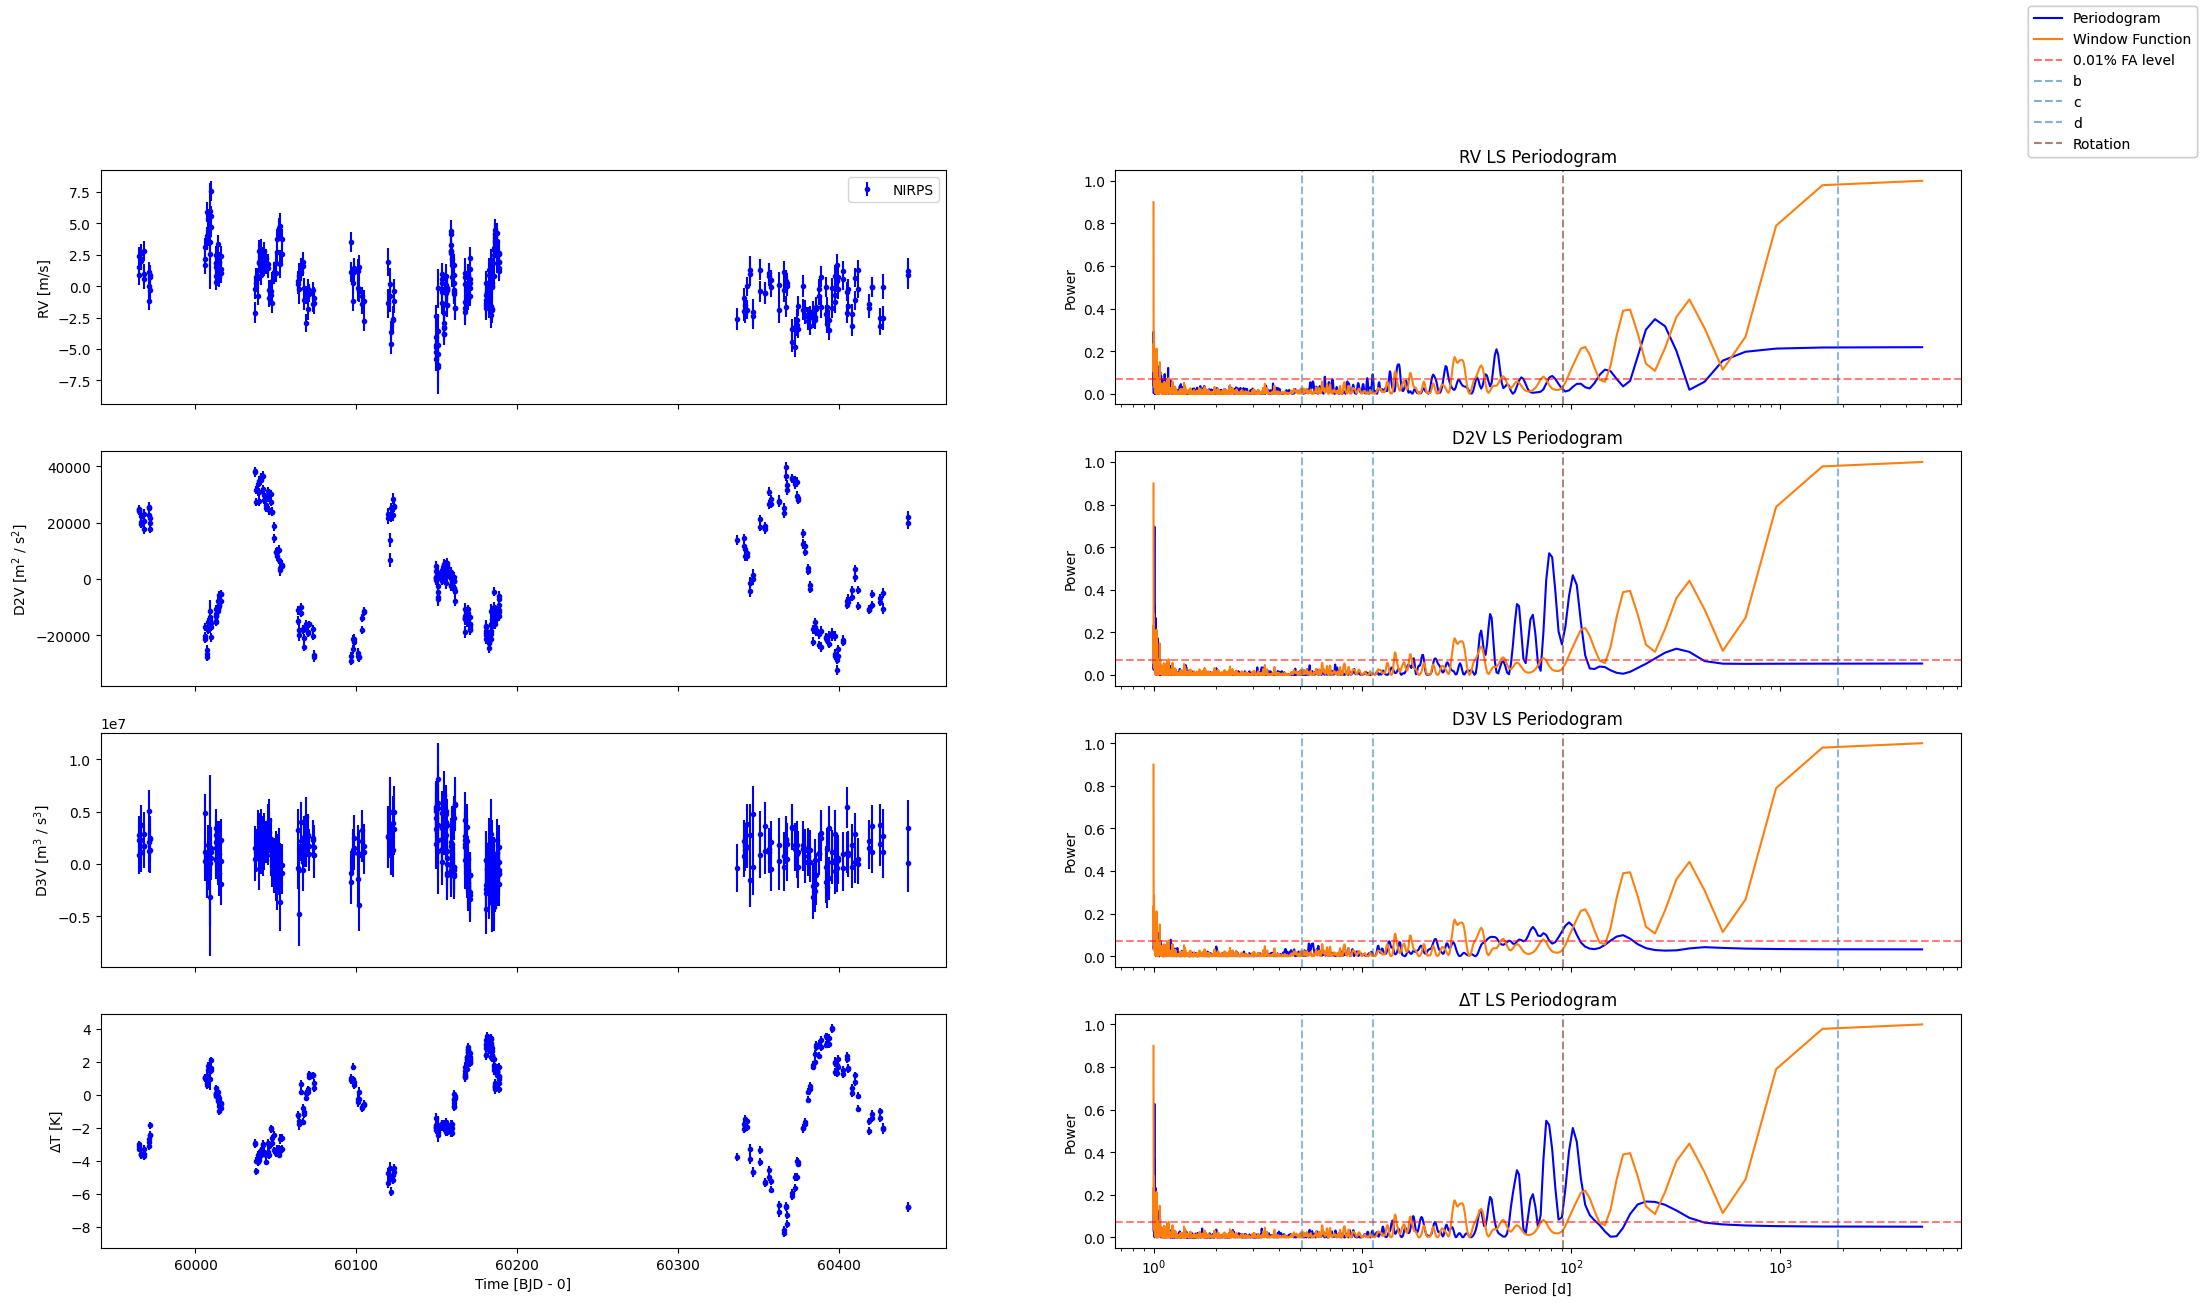

In [5]:
first_time = True
for instrument in instruments: 
    if first_time: 
        fig, axes = nirps.plot_timeseries(tbl[instrument], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=system_info['planets'], star_rotation=system_info['period'], color = 'blue')
    else: 
        nirps.plot_timeseries(tbl[instrument], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=system_info['planets'], star_rotation=system_info['period'], color = 'red',fig = fig, axes=axes)
        
    
    first_time = False
    
axes[0, 0].legend()
plt.savefig(f"stars/{star}/data/{star}_timeseries.png", dpi=300)
plt.show()

CCF data (v3.0.0)

In [6]:
first_time = True
for instrument in instruments: 
    if first_time: 
        if ccf[instrument]['DRS-3-0-0']: 
            nirps.plot_timeseries(tbl_ccf[instrument]['DRS-3-0-0'], qty_ccf_list[instrument], qty_labels=qty_ccf_labels[instrument], qty_units=qty_ccf_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=system_info['planets'], star_rotation=system_info['period'], color = 'green', axes=axes, inc_label='sig_')
            first_time = False
            
    else:  
        if ccf[instrument]['DRS-3-0-0']: 
            nirps.plot_timeseries(tbl_ccf[instrument]['DRS-3-0-0'], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=system_info['planets'], star_rotation=system_info['period'], color = 'green',fig = fig, axes=axes, inc_label='sig_')
            
axes[0, 0].legend()
plt.savefig(f"stars/{star}/data/{star}_CCF_timeseries.png", dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

## Outlier filtering

In [7]:
mask_sigma = {}
mask_sigma_ccf = {}
for instrument in instruments: 
    mask_sigma[instrument] = nirps.sigma_clip_tbl(tbl[instrument], qty_list[instrument], sigma=3.0)
    
    if ccf[instrument]['DRS-3-0-0']:
        mask_sigma_ccf[instrument] = nirps.sigma_clip_tbl(tbl_ccf[instrument]['DRS-3-0-0'], qty_ccf_list[instrument], sigma=3.0)

/home/plamontagne/nirps/nirps_tools.py:132: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  axes[i, 0].errorbar(t, y, yerr=yerr, fmt=err_fmt, label=err_label, color=color)
/home/plamontagne/nirps/nirps_tools.py:132: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  axes[i, 0].errorbar(t, y, yerr=yerr, fmt=err_fmt, label=err_label, color=color)


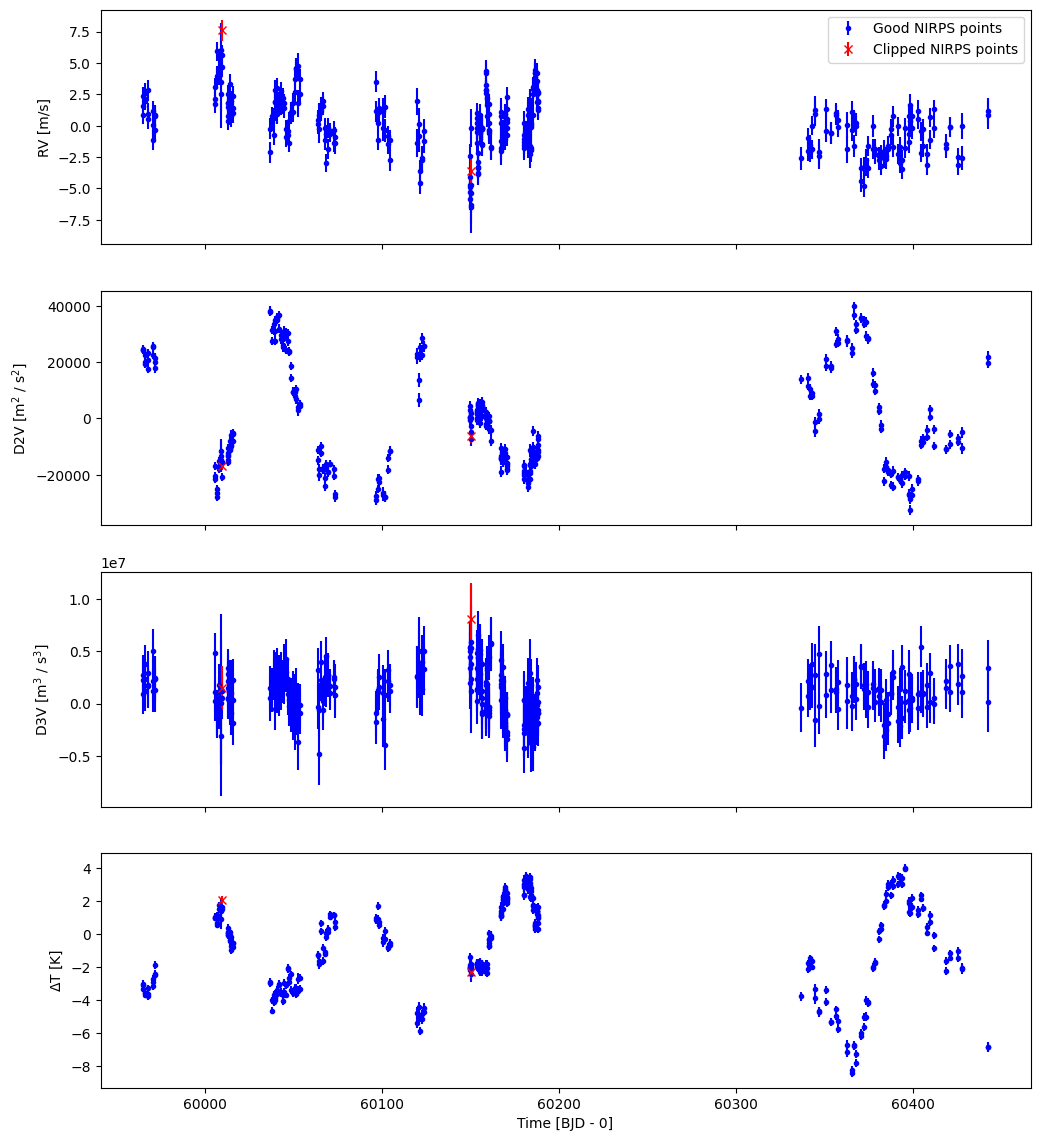

In [8]:
first_time = True
for instrument in instruments: 
    if first_time:
        fig, axes = nirps.plot_timeseries(
            tbl[instrument][~mask_sigma[instrument]], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument], plot_ls=False,
            err_label=f"Good {instrument} points", color='blue')
        
        nirps.plot_timeseries(tbl[instrument][mask_sigma[instrument]], 
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="rx",
        err_label=f"Clipped {instrument} points",
        color='red')
        
    else:  
        nirps.plot_timeseries(
        tbl[instrument][~mask_sigma[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_label=f"Good {instrument} points",
        color='purple')
        
        nirps.plot_timeseries(
        tbl[instrument][mask_sigma[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="rx",
        err_label=f"Clipped {instrument} points",
        color='orange')
    
    first_time = False
        
axes[0, 0].legend()
plt.show()

## Error-based filtering

NIRPS


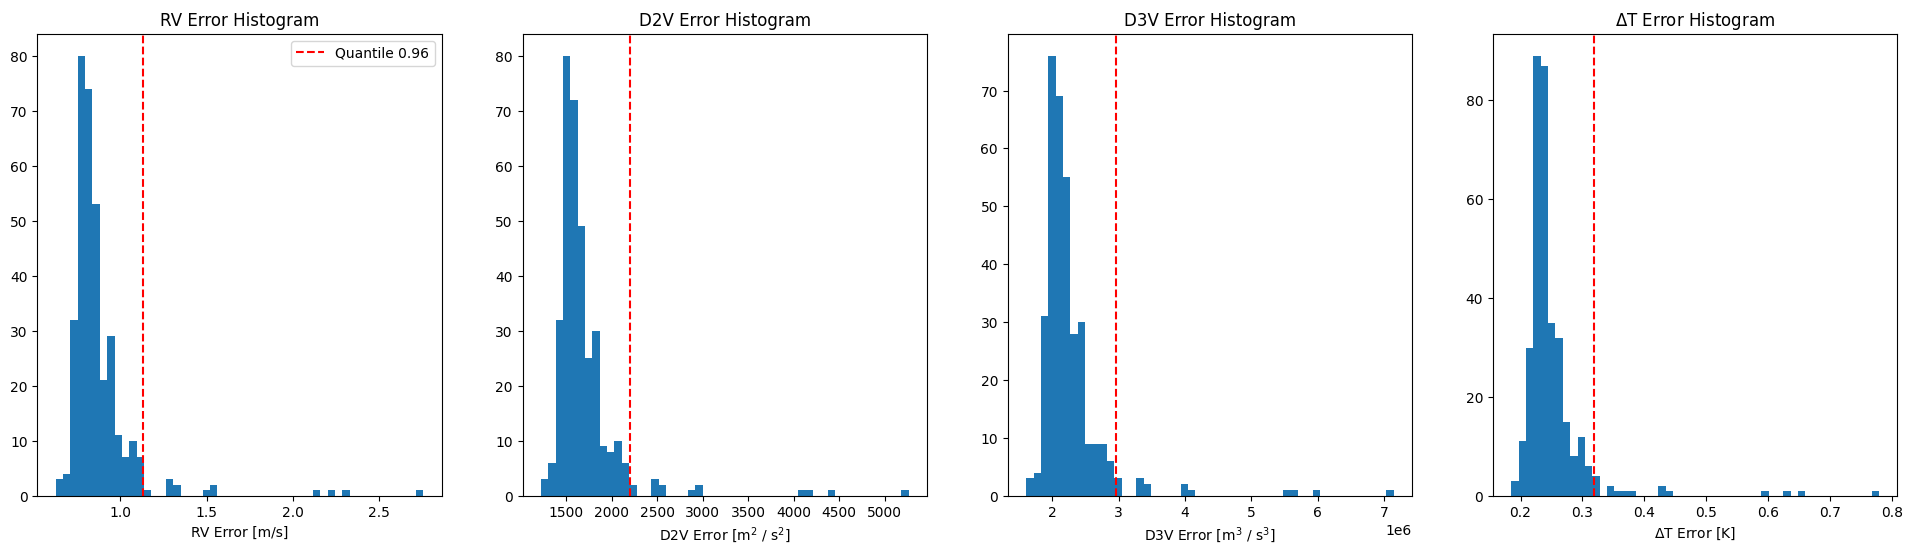

In [9]:
quantile_cut = 0.96
mask_equant = {}
mask_equant_ccf = {}

# LBL data
for instrument in instruments: 
    print(instrument)
    nirps.plot_error_dist(tbl[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument], quantile_cut=quantile_cut)
    plt.show()

    mask_equant[instrument] = nirps.error_quantile_clip(tbl[instrument], qty_list[instrument], quantile_cut, inc_label='s')
    
# CCF data
for instrument in instruments: 
    if ccf[instrument]['DRS-3-0-0']:
        mask_equant_ccf[instrument] = nirps.error_quantile_clip(tbl_ccf[instrument]['DRS-3-0-0'], qty_ccf_list[instrument], quantile_cut, inc_label='sig_')

/home/plamontagne/nirps/nirps_tools.py:132: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx" (-> color='b'). The keyword argument will take precedence.
  axes[i, 0].errorbar(t, y, yerr=yerr, fmt=err_fmt, label=err_label, color=color)


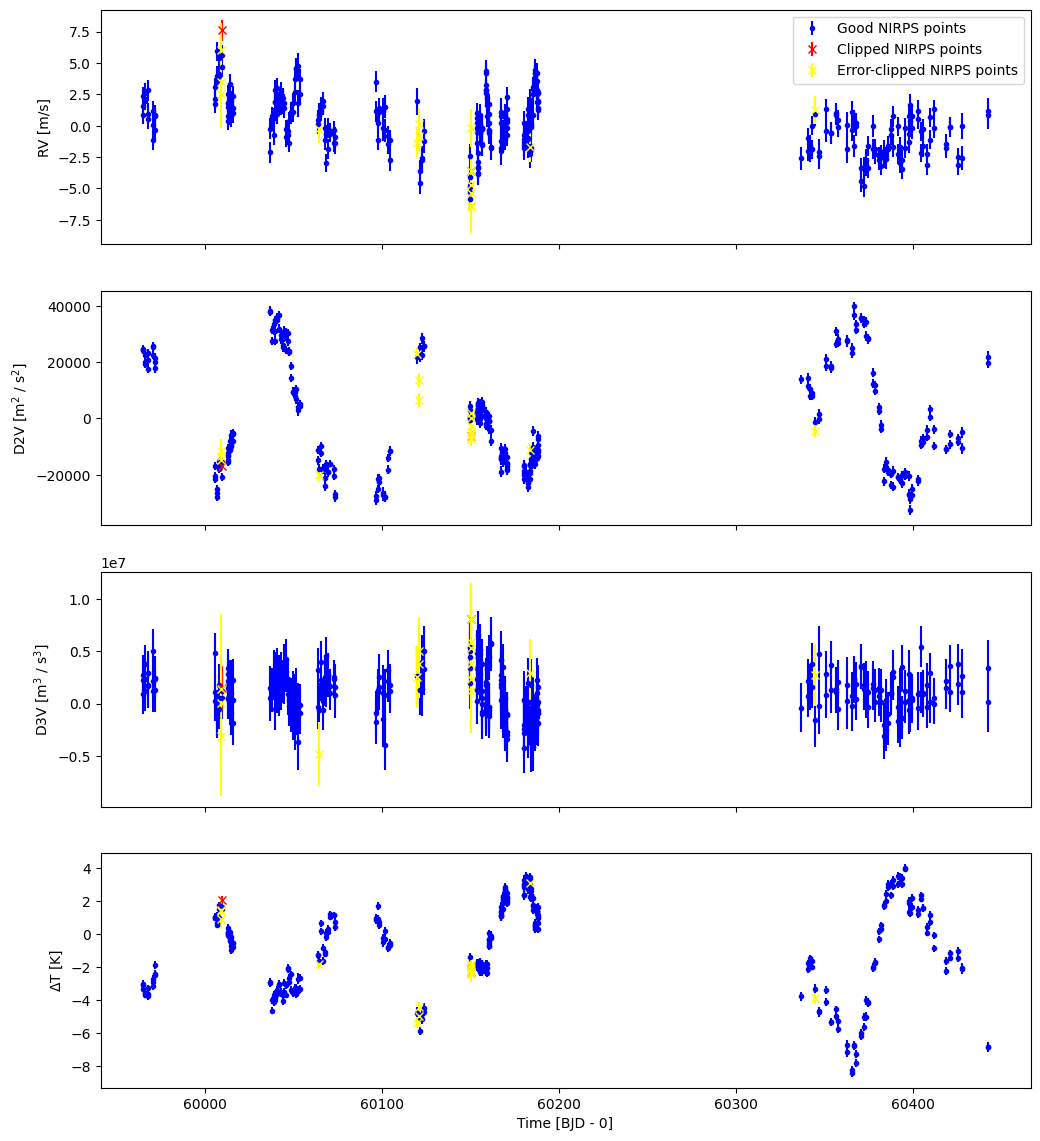

In [10]:
first_time = True
mask = {}
mask_ccf = {}

for instrument in instruments: 
    mask[instrument] = mask_sigma[instrument] | mask_equant[instrument]
    if first_time:
        fig, axes = nirps.plot_timeseries(
            tbl[instrument][~mask[instrument]], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument], plot_ls=False,
            err_label=f"Good {instrument} points", color='blue')
        
        nirps.plot_timeseries(
        tbl[instrument][mask_sigma[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="rx",
        err_label=f"Clipped {instrument} points",
        color='red')
        
        nirps.plot_timeseries(
        tbl[instrument][mask_equant[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="bx",
        err_label=f"Error-clipped {instrument} points",
        color='yellow'
    )
        
    else:  
        nirps.plot_timeseries(
        tbl[instrument][~mask[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_label=f"Good {instrument} points",
        color='purple')
        
        nirps.plot_timeseries(
        tbl[instrument][mask_sigma[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="rx",
        err_label=f"Clipped {instrument} points",
        color='orange')
        
        nirps.plot_timeseries(
        tbl[instrument][mask_equant[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="bx",
        err_label=f"Error-clipped {instrument} points",
        color='green'
    )
    
    first_time = False
        
axes[0, 0].legend()
plt.show()

### Preprocessed data

In [11]:
# Save the preprocessed data in a new .rdb file

i=0
for instrument in instruments: 

    tbl[instrument] = tbl[instrument][~mask[instrument]]
    tbl[instrument].write(files[instrument]+'_preprocessed.rdb', overwrite=True)
    
    # CCF data
    if ccf[instrument]['DRS-3-0-0']:
        mask_ccf[instrument] = mask_sigma_ccf[instrument] | mask_equant_ccf[instrument]
        tbl_ccf[instrument]['DRS-3-0-0'][~mask_equant_ccf[instrument]].write(f'stars/{star}/data/{star}_{instrument}_DRS-3-0-0_preprocessed.rdb', overwrite=True)
    
    i+=1

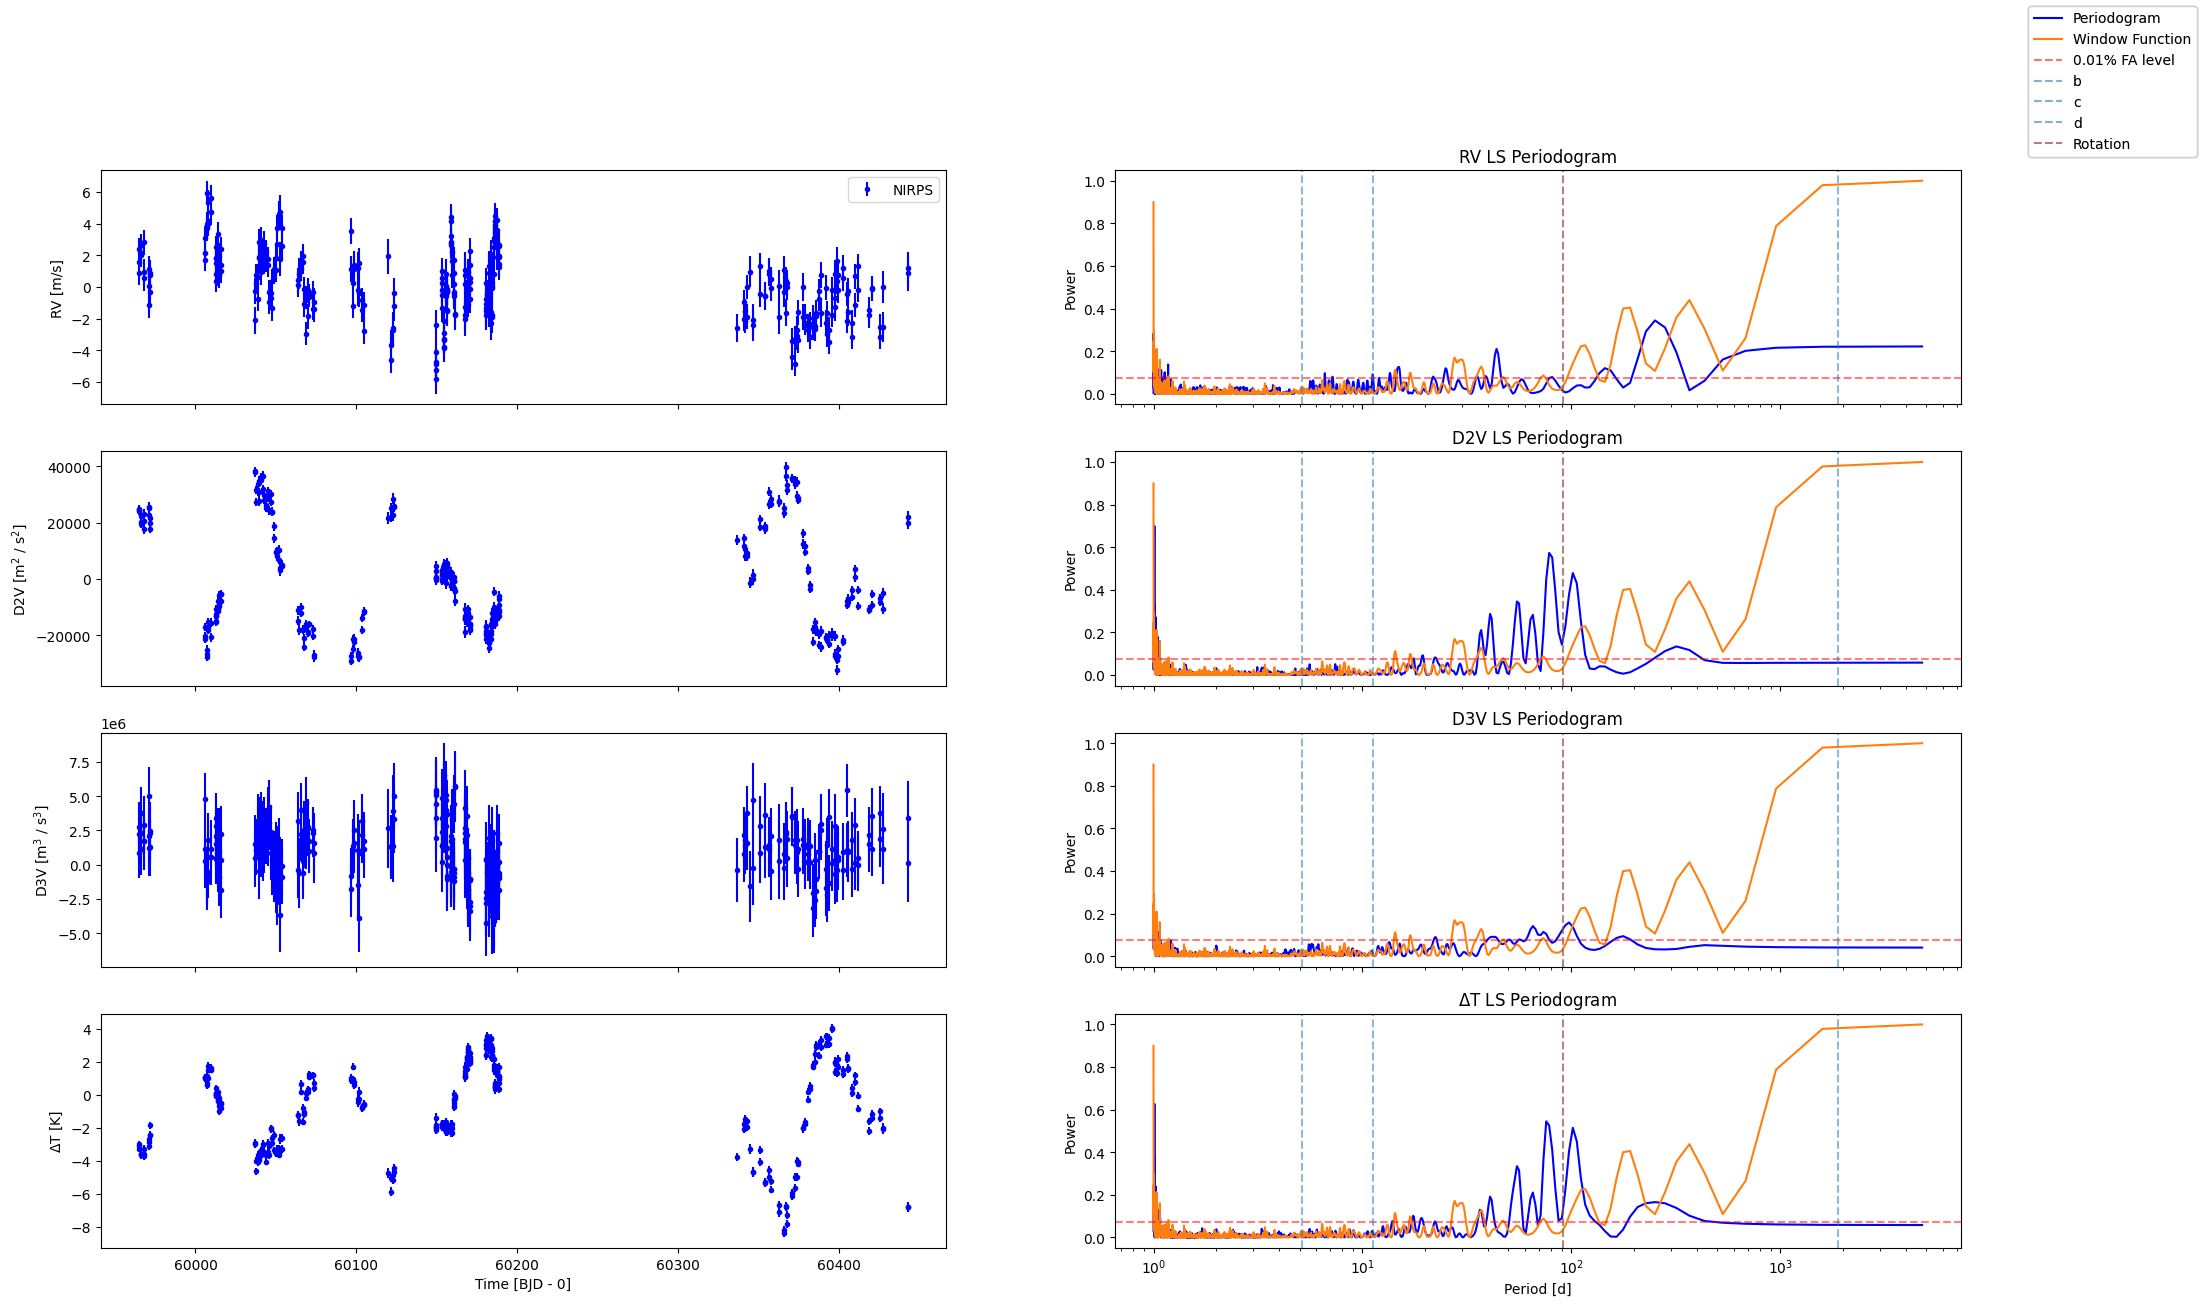

In [12]:
# Plot the preprocessed data

first_time = True
for instrument in instruments: 
    if first_time: 
        fig, axes = nirps.plot_timeseries(tbl[instrument], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=system_info['planets'], star_rotation=system_info['period'], color = 'blue')
    else: 
        nirps.plot_timeseries(tbl[instrument], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=system_info['planets'], star_rotation=system_info['period'], color = 'red',fig = fig, axes=axes)
        
    
    first_time = False
    
axes[0, 0].legend()
plt.savefig(f"stars/{star}/data/{star}_timeseries_after_correction.png", dpi=300)
plt.show()

# Diagnostic plots

## Chromatic slopes

KeyError: 'HARPS'

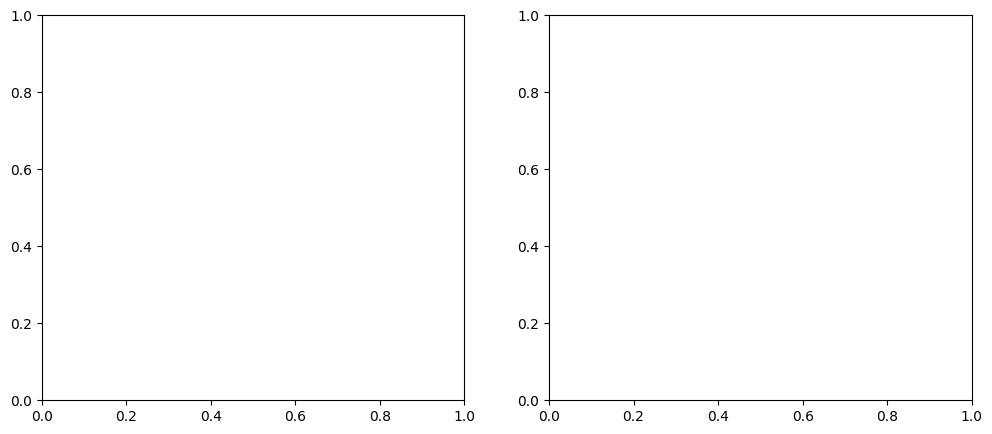

In [13]:
# Plot histograms of the chromatic slopes
fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].hist((tbl['HARPS']['vrad_chromatic_slope']-np.median(tbl['HARPS']['vrad_chromatic_slope']))/tbl['HARPS']['svrad_chromatic_slope'], 
             histtype='step', label='HARPS', color='blue')
axes[0].hist((tbl['NIRPS']['vrad_chromatic_slope']-np.median(tbl['NIRPS']['vrad_chromatic_slope']))/tbl['NIRPS']['svrad_chromatic_slope'],
                histtype='step', label='NIRPS', color='red')
axes[0].set_ylabel('Counts')
axes[0].set_xlabel('Chromatic slope')
axes[0].legend()
axes[0].set_title('Normalized chromatic slope distribution')

axes[1].errorbar(tbl['HARPS']['rjd'], tbl['HARPS']['vrad_chromatic_slope'], yerr=tbl['HARPS']['svrad_chromatic_slope'],
                 label='HARPS', color='blue', fmt = 'o', markersize = 3)
axes[1].errorbar(tbl['NIRPS']['rjd'], tbl['NIRPS']['vrad_chromatic_slope'], yerr=tbl['NIRPS']['svrad_chromatic_slope'],
                 label='NIRPS', color='red', fmt = 'o', markersize = 3)
axes[1].set_xlabel('Time (RJD)')
axes[1].set_ylabel('Chromatic slope')
axes[1].set_title('Timeseries of chromatic slope')
axes[1].legend()

plt.show()

## FWHM 

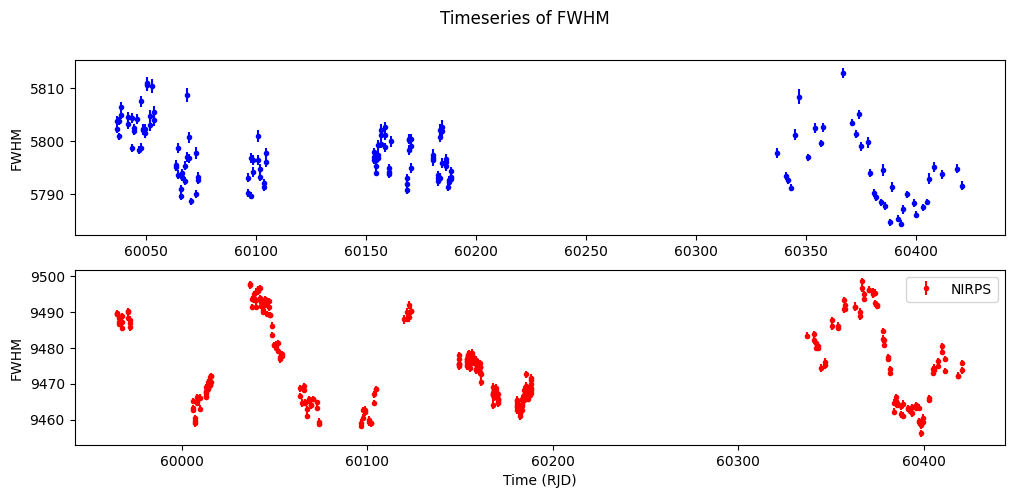

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(12,5))

axes[0].errorbar(tbl['HARPS']['rjd'], tbl['HARPS']['fwhm'], yerr = tbl['HARPS']['sig_fwhm'],
            label='HARPS', color='blue', fmt = 'o', markersize = 3)
axes[1].errorbar(tbl['NIRPS']['rjd'], tbl['NIRPS']['fwhm'], yerr = tbl['NIRPS']['sig_fwhm'],
            label='NIRPS', color='red', fmt = 'o', markersize = 3)

axes[1].set_xlabel('Time (RJD)')
axes[0].set_ylabel('FWHM')
axes[1].set_ylabel('FWHM')
plt.suptitle('Timeseries of FWHM')
plt.legend()
plt.show()

## Winds for $H_2O$ and other species

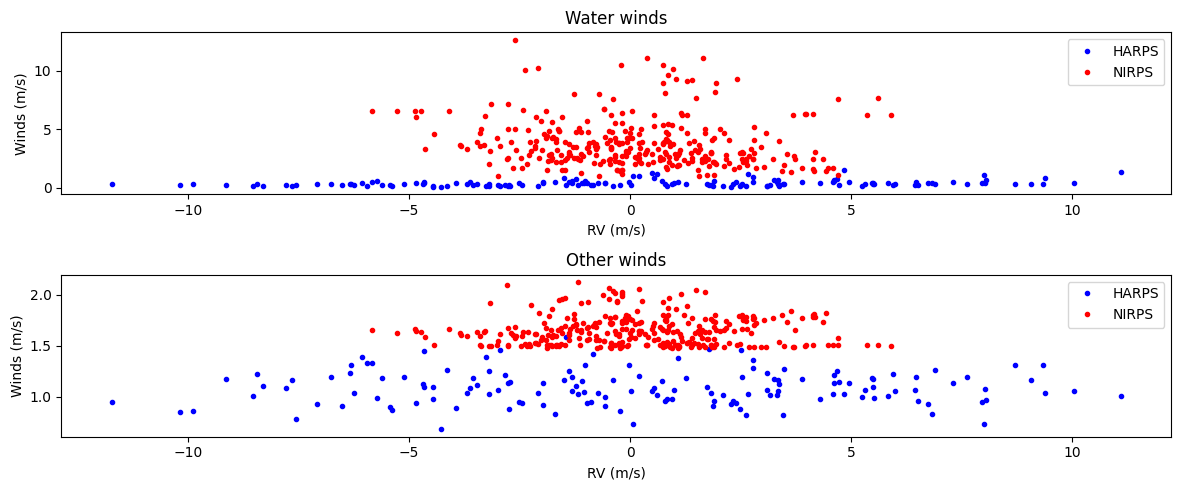

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(12,5))

# Water winds
axes[0].plot(tbl['HARPS']['vrad'], tbl['HARPS']['TLPEH2O'], 'o', label='HARPS', color='blue', markersize = 3)
axes[0].plot(tbl['NIRPS']['vrad'], tbl['NIRPS']['TLPEH2O'], 'o', label='NIRPS', color='red', markersize = 3)
axes[0].set_xlabel('RV (m/s)')
axes[0].set_ylabel('Winds (m/s)')
axes[0].set_title('Water winds')
axes[0].legend()

# Other species winds
axes[1].plot(tbl['HARPS']['vrad'], tbl['HARPS']['TLPEOTR'], 'o', label='HARPS', color='blue', markersize = 3)
axes[1].plot(tbl['NIRPS']['vrad'], tbl['NIRPS']['TLPEOTR'], 'o', label='NIRPS', color='red', markersize = 3)
axes[1].set_xlabel('RV (m/s)')
axes[1].set_ylabel('Winds (m/s)')
axes[1].set_title('Other winds')
axes[1].legend()

plt.tight_layout()
plt.show()


## Left side/Right side of the detector

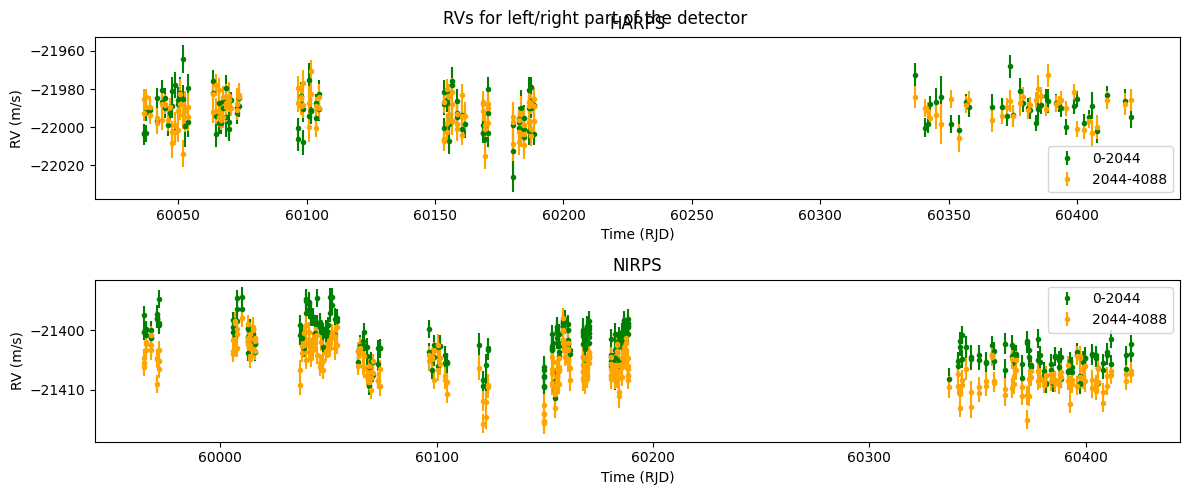

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(12,5))

# HARPS
axes[0].errorbar(tbl['HARPS']['rjd'], tbl['HARPS']['vrad_g_0-2044'], yerr=tbl['HARPS']['svrad_g_0-2044'],
              fmt='o', color='green', label='0-2044', markersize=3)
axes[0].errorbar(tbl['HARPS']['rjd'], tbl['HARPS']['vrad_g_2044-4088'], yerr=tbl['HARPS']['svrad_g_2044-4088'],
              fmt='o', color='orange', label='2044-4088', markersize=3)
axes[0].set_xlabel('Time (RJD)')
axes[0].set_ylabel('RV (m/s)')
axes[0].set_title('HARPS')
axes[0].legend()

# NIRPS
axes[1].errorbar(tbl['NIRPS']['rjd'], tbl['NIRPS']['vrad_h_0-2044'], yerr=tbl['NIRPS']['svrad_h_0-2044'],
              fmt='o', color='green', label='0-2044', markersize=3)
axes[1].errorbar(tbl['NIRPS']['rjd'], tbl['NIRPS']['vrad_h_2044-4088'], yerr=tbl['NIRPS']['svrad_h_2044-4088'],
              fmt='o', color='orange', label='2044-4088', markersize=3)
axes[1].set_xlabel('Time (RJD)')
axes[1].set_ylabel('RV (m/s)')
axes[1].set_title('NIRPS')
axes[1].legend()

plt.tight_layout()
plt.suptitle('RVs for left/right part of the detector')
plt.show()

## $V_{tot}$

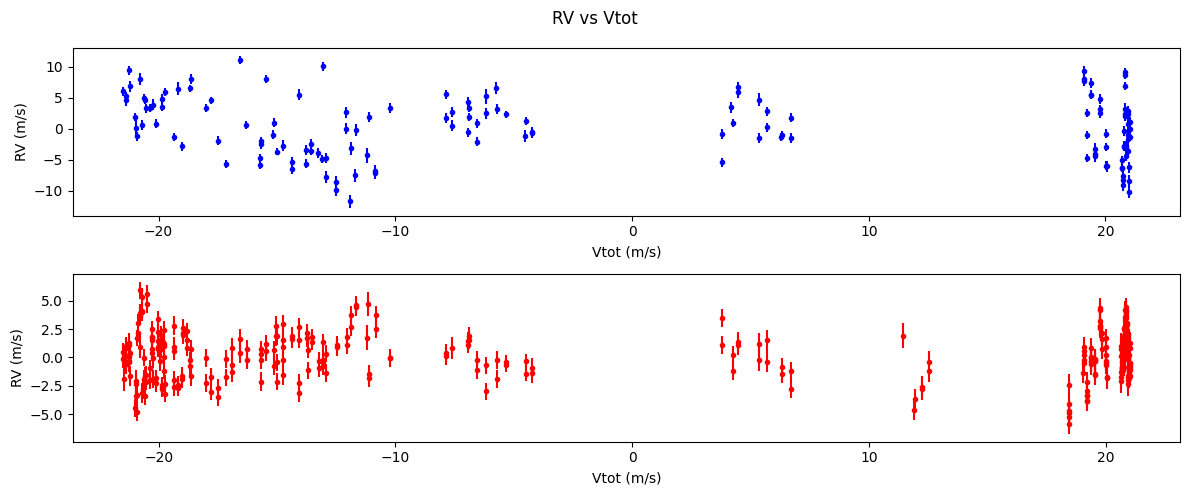

In [ ]:
vtot_HARPS = tbl['HARPS']['vrad']/1e3-tbl['HARPS']['HIERARCH ESO DRS BERV']
i_sort_HARPS = np.argsort(vtot_HARPS)

vtot_NIRPS = tbl['NIRPS']['vrad']/1e3-tbl['NIRPS']['BERV']
i_sort_NIRPS = np.argsort(vtot_NIRPS)

fig, axes = plt.subplots(2,1, figsize=(12,5))

# HARPS
axes[0].errorbar(vtot_HARPS[i_sort_HARPS], tbl['HARPS']['vrad'][i_sort_HARPS], yerr = tbl['HARPS']['svrad'][i_sort_HARPS],
                 fmt='o', color='blue', label='HARPS', markersize=3)
axes[0].set_xlabel('Vtot (m/s)')
axes[0].set_ylabel('RV (m/s)')

axes[1].errorbar(vtot_NIRPS[i_sort_NIRPS], tbl['NIRPS']['vrad'][i_sort_NIRPS], yerr = tbl['NIRPS']['svrad'][i_sort_NIRPS],
                 fmt='o', color='red', label='NIRPS', markersize=3)
axes[1].set_xlabel('Vtot (m/s)')
axes[1].set_ylabel('RV (m/s)')

plt.suptitle('RV vs Vtot')
plt.tight_layout()
plt.show()